# ALMA configuration tests

Date   : 28/05/2018 <br> 
Author : SL  <br>
Code   : https://github.com/bosscha/alma

## Scope

Analysis of ALMA configuration with the 7m+12m configurations together <br>

**Steps:**
1. Create the array configuration combining ACA-std.cfg with C43-x.cfg into AFC-x  (ALMA Full Configuration) <br>
2. Run the Simulations with the Halpha emission in M51 on AFC-x and 7m/C43-x separately.  Note that a time ratio of 1h:5h is taken for the separate case.<br>
3. The fidelity f of the images is analyzed to compare the two options. As a reminder for the fidelity definition: <br>
$$ f = \lvert \frac{I}{I-O} \rvert $$ <br>
where I is the original image convoluted to the spatial resolution and O the simulated image. <br>
4. We compute the density rho of the fidelity f and the different moments of:
$$ M_i(\rho) = \int f^i \rho(f) df $$ <br>
and the **Mutual Information I**: <br>
$$  I(x,y) = \sum_{x,y} P(x,y) \ln {{P(x,y)}\over{P(x) P(y)}} $$
The sum excludes terms with P(x,y)=0. The base 2 logarithm is often used, in which case result is in units of bits. The natural logarithm can alternatively be used, in which case the result is in units of nats. In this notebook we use the natural log.<br>
<br>
We compute the mutual information between the original image *x* convolved by the synthesized beam and the simulated image *y*. This is a metric for the adequation of the simulated image wrt. the original image. The higher the mutual information the closer the simulated image is. <br>

How to reproduce it: 
- > casa -c runSimulations.py   ## script in src/run  with array configuration file in notebooks/data and results in notebooks/results
- run locally the notebook AFC-simul.ipynb  after cloning (git clone https://github.com/bosscha/alma master)


In [1]:
import os, shutil , glob
import matplotlib.pyplot as pl
from pylab import rcParams
import numpy as np
import math

from astropy.io import fits
from astropy.stats import histogram
from astropy.wcs import WCS

%matplotlib inline


In [2]:
## Run the simulation locally.
## Be patient ...

# os.system("casa -c ../src/run/runSimulations.py")

In [3]:
def integrate(rho,xmin, dx):
    "the different moment of a density function"
    
    moment = np.array([0.,0.,0.,0., 0.])
    kb = -1.
    
    x= xmin
    for i in range(len(rho)):
        moment[0] += rho[i]*dx
        moment[1] += x*rho[i] *dx
        moment[2] += x*x*rho[i]*dx
        moment[3] += x*x*x*rho[i]*dx
        if rho[i] > 0.:
            moment[4] +=  kb * rho[i] * math.log(rho[i]) * dx
        x += dx
        
    return(moment)
        

In [4]:
def MutualInformation(im1, im2, binsize = 20):
    "Compute the mutual information between im1 and im2. It is an entropy-based metric."
    
    
    hgram, x_edges, y_edges = np.histogram2d(im1.ravel(), im2.ravel(), bins = binsize)
    
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    mi = np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))
    
    return(mi)

In [5]:
## Analysis function

def analysis_image(index, caption):
    
    sim1 = "AFC-%d.alma.afc-%d.image.fits"%(index, index)
    fid1  = "AFC-%d.alma.afc-%d.fidelity.fits"%(index, index)
    model1 = "AFC-%d.alma.afc-%d.skymodel.flat.regrid.conv.fits"%(index, index)
    
    sim2 = "C43-%d+ACA.concat.image.fits"%(index)
    fid2  =  "C43-%d+ACA.concat.fidelity.fits"%(index)
    model2 = "C43-%d+ACA.concat.skymodel.flat.regrid.conv.fits"%(index)
    
    nbin = 500
    fmax = 1.5
    mibin = 20
    
    with fits.open(model1) as m1:
        in1 = m1[0].data
        
    with fits.open(sim1) as s1:
        out1 = s1[0].data 
        
    with fits.open(fid1) as hf1:
        datf1 = hf1[0].data      
        rhof1 = histogram(datf1,bins = nbin , range = [0.,fmax], density = True)
        mom1 = integrate(rhof1[0], 0. , fmax/nbin)
     
    mi1 = MutualInformation(in1, out1, mibin) 

    with fits.open(model2) as m2:
        in2 = m2[0].data
        
    with fits.open(sim2) as s2:
        out2 = s2[0].data 
        
    with fits.open(fid2) as hf2:
        datf2 = hf2[0].data
        rhof2 = histogram(datf2,bins = nbin , range = [0.,fmax], density = True)
        mom2 = integrate(rhof2[0], 0. , fmax/nbin)     
     
    mi2 = MutualInformation(in2, out2, mibin) 
    
    rcParams['figure.figsize'] = 7, 5

    pl.plot(rhof1[1][0:-1],rhof1[0], "b-", label="AFC-%d"%(index))
    pl.plot(rhof2[1][0:-1],rhof2[0], "r--",label="C43-%d+ACA"%(index))
    pl.ylabel(r"$\rho(f)$")
    pl.xlabel(r"$f$")
    pl.xlim([0.,fmax])
    pl.ylim([0.,15.])
    pl.legend(loc = "upper right")            

    pl.show()
        
    print(r"## Simulation: AFC-%d"%(index))
    print("## M1 : %f"%(mom1[1]))
    print("## M2 : %f"%(mom1[2]))
    print("## M3 : %f"%(mom1[3]))
    print("## I : %f nats"%(mi1))
    print("")
    print(r"## Simulation: C43-%d+ACA"%(index))
    print("## M1 : %f"%(mom2[1]))
    print("## M2 : %f"%(mom2[2]))
    print("## M3 : %f"%(mom2[3]))
    print("## I  : %f nats"%(mi2))
    print("\n I ratio: %f"%(mi1/mi2))


## Analysis ...

In [6]:
wdir = "/home/stephane/Science/ALMA/ArrayConfig/imaging/fullcombination/master/notebooks/products"
os.chdir(wdir)

-------------------------
## AFC-1 vs. C43-1+7m

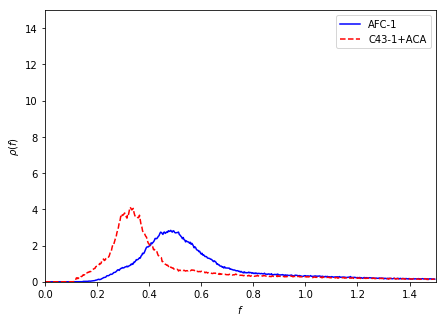

## Simulation: AFC-1
## M1 : 0.609959
## M2 : 0.443455
## M3 : 0.383288
## I : 0.445587 nats

## Simulation: C43-1+ACA
## M1 : 0.495789
## M2 : 0.336516
## M3 : 0.298847
## I  : 0.531178 nats

 I ratio: 0.838866


In [7]:
analysis_image(1,"AFC-1")

**Beam properties: AFC-1**

In [8]:
f = open("AFC-1-beam.txt")
print(f.read())
f.close()

## Project: AFC-1 
## 
## Sidelobe  : 7.319113 
## Major axis: 3.642370 
## Minor axis: 2.172362 
## AR: 2.812925 
-------------



**Beam properties: C43-1+ACA**

In [9]:
f = open("C43-1+ACA-beam.txt")
print(f.read())
f.close()

## Project: C43-1+ACA 
## 
## Sidelobe  : 7.389624 
## Major axis: 3.609602 
## Minor axis: 3.547820 
## AR: 3.578577 
-------------



### Notes

**Critical antennas** (20): <br>
**AFC-1**: A011 [100.00 %]  J505 [94.79 %]  A033 [23.25 %]  A049 [14.63 %]  A044 [11.29 %]  A015 [8.26 %]  J504 [8.06 %]  N602 [7.12 %]  J506 [6.99 %]  A007 [5.83 %]  N601 [5.25 %]  N604 [4.91 %]  A027 [4.54 %]  N606 [4.18 %]  A047 [4.12 %]  A005 [4.04 %]  A006 [3.99 %]  A038 [3.82 %]  A045 [3.63 %]  A031 [3.61 %] <br>
<br>
**C43-1** : A028 [100.00 %]  A047 [99.26 %]  A033 [41.85 %]  A049 [35.19 %]  A007 [13.56 %]  A016 [10.60 %]  A015 [10.47 %]  A024 [10.15 %]  A023 [9.54 %]  A027 [9.35 %]  A011 [9.19 %]  A045 [9.10 %]  A005 [8.96 %]  A008 [8.65 %]  A022 [8.42 %]  A006 [8.42 %]  A010 [8.26 %]  A038 [8.23 %]  A043 [8.22 %]  A044 [7.90 %]  


----------------------------
## AFC-2 vs. C43-2+7m

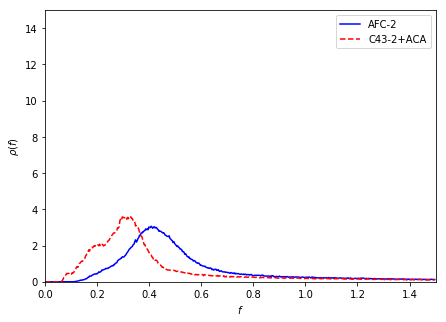

## Simulation: AFC-2
## M1 : 0.540857
## M2 : 0.365275
## M3 : 0.306409
## I : 0.415532 nats

## Simulation: C43-2+ACA
## M1 : 0.422373
## M2 : 0.261213
## M3 : 0.223234
## I  : 0.500798 nats

 I ratio: 0.829739


In [10]:
analysis_image(2,"AFC-2")

**Beam properties: AFC-2**

In [11]:
f = open("AFC-2-beam.txt")
print(f.read())
f.close()

## Project: AFC-2 
## 
## Sidelobe  : 9.423035 
## Major axis: 2.592033 
## Minor axis: 1.801081 
## AR: 2.160662 
-------------



**Beam properties: C43-2+ACA**

In [12]:
f = open("C43-2+ACA-beam.txt")
print(f.read())
f.close()

## Project: C43-2+ACA 
## 
## Sidelobe  : 8.768897 
## Major axis: 2.579238 
## Minor axis: 2.494306 
## AR: 2.536417 
-------------



-------------------------
## AFC-3 vs. C43-3+7m

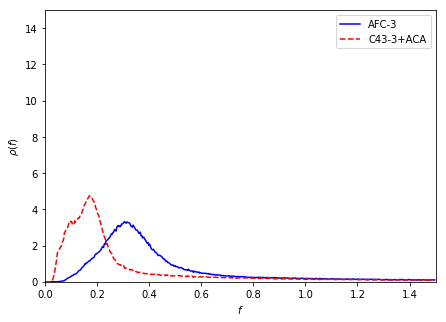

## Simulation: AFC-3
## M1 : 0.437698
## M2 : 0.267166
## M3 : 0.220595
## I : 0.357273 nats

## Simulation: C43-3+ACA
## M1 : 0.304050
## M2 : 0.182660
## M3 : 0.166344
## I  : 0.335448 nats

 I ratio: 1.065065


In [13]:
analysis_image(3,"AFC-3")

**Beam properties: AFC-3**

In [14]:
f = open("AFC-3-beam.txt")
print(f.read())
f.close()

## Project: AFC-3 
## 
## Sidelobe  : 8.653451 
## Major axis: 1.665849 
## Minor axis: 1.335287 
## AR: 1.491438 
-------------



**Beam properties: C43-3+ACA**

In [15]:
f = open("C43-3+ACA-beam.txt")
print(f.read())
f.close()

## Project: C43-3+ACA 
## 
## Sidelobe  : 8.655073 
## Major axis: 1.669455 
## Minor axis: 1.507637 
## AR: 1.586484 
-------------



-------------------------
## AFC-4 vs. C43-4+7m

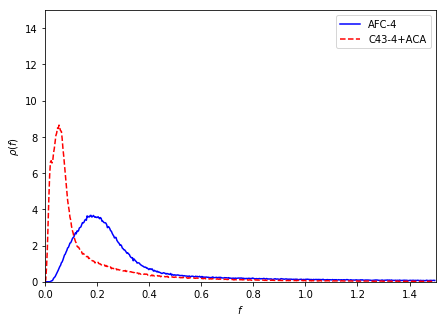

## Simulation: AFC-4
## M1 : 0.319817
## M2 : 0.176820
## M3 : 0.148203
## I : 0.294590 nats

## Simulation: C43-4+ACA
## M1 : 0.173530
## M2 : 0.083794
## M3 : 0.067142
## I  : 0.213304 nats

 I ratio: 1.381081


In [16]:
analysis_image(4,"AFC-4")

**Beam properties: AFC-4**

In [17]:
f = open("AFC-4-beam.txt")
print(f.read())
f.close()

## Project: AFC-4 
## 
## Sidelobe  : 10.764413 
## Major axis: 1.031002 
## Minor axis: 0.930857 
## AR: 0.979651 
-------------



**Beam properties: C43-4+ACA**

In [18]:
f = open("C43-4+ACA-beam.txt")
print(f.read())
f.close()

## Project: C43-4+ACA 
## 
## Sidelobe  : 16.244413 
## Major axis: 1.026832 
## Minor axis: 0.964831 
## AR: 0.995349 
-------------



-------------------------
## AFC-5 vs. C43-5+7m

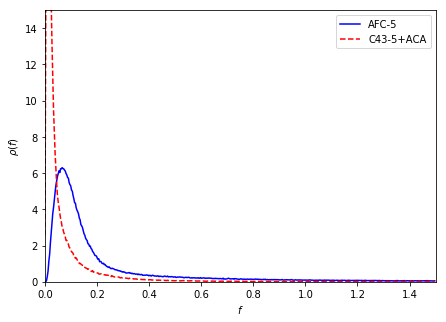

## Simulation: AFC-5
## M1 : 0.215209
## M2 : 0.118075
## M3 : 0.104339
## I : 0.214071 nats

## Simulation: C43-5+ACA
## M1 : 0.067912
## M2 : 0.021222
## M3 : 0.014587
## I  : 0.154829 nats

 I ratio: 1.382625


In [19]:
analysis_image(5,"AFC-5")

**Beam properties: AFC-5**

In [20]:
f = open("AFC-5-beam.txt")
print(f.read())
f.close()

## Project: AFC-5 
## 
## Sidelobe  : 9.285825 
## Major axis: 0.604343 
## Minor axis: 0.585970 
## AR: 0.595086 
-------------



**Beam properties: C43-5+ACA**

In [21]:
f = open("C43-5+ACA-beam.txt")
print(f.read())
f.close()

## Project: C43-5+ACA 
## 
## Sidelobe  : 10.365462 
## Major axis: 0.595495 
## Minor axis: 0.576276 
## AR: 0.585807 
-------------



-------------------------
## AFC-6 vs. C43-6+7m

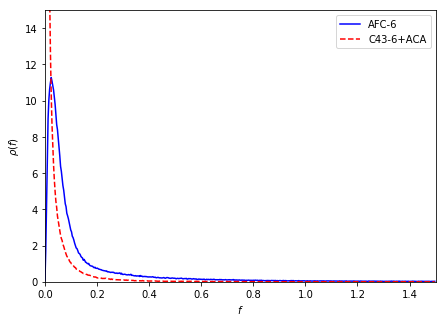

## Simulation: AFC-6
## M1 : 0.140627
## M2 : 0.068016
## M3 : 0.056473
## I : 0.160945 nats

## Simulation: C43-6+ACA
## M1 : 0.038319
## M2 : 0.009058
## M3 : 0.005631
## I  : 0.145624 nats

 I ratio: 1.105208


In [22]:
analysis_image(6,"AFC-6")

**Beam properties: AFC-6**

In [23]:
f = open("AFC-1-beam.txt")
print(f.read())
f.close()

## Project: AFC-1 
## 
## Sidelobe  : 7.319113 
## Major axis: 3.642370 
## Minor axis: 2.172362 
## AR: 2.812925 
-------------



**Beam properties: C43-6+ACA**

In [24]:
f = open("C43-1+ACA-beam.txt")
print(f.read())
f.close()

## Project: C43-1+ACA 
## 
## Sidelobe  : 7.389624 
## Major axis: 3.609602 
## Minor axis: 3.547820 
## AR: 3.578577 
-------------

